In [1]:
import maxrf4u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.exposure as ske
import moseley as mos
import numpy as np
import os
import re

In [2]:
%matplotlib widget

In [3]:
datastack_file = '/home/koen-van-tilburg/Documents/maxrf4u/data/datastacks/WM-71803-01_400_600_50.datastack'
datastack_file2 = '/home/koen-van-tilburg/Documents/maxrf4u/data/datastacks/WM-71803-10_250_300_50.datastack'
ds = maxrf4u.DataStack(datastack_file)
ds.tree()

/
├── compton_peak_energy (1,) float64
├── hotmax_baselines (32, 4096) float64
├── hotmax_noiselines (32, 4096) float64
├── hotmax_peak_idxs_flat (33,) int64
├── hotmax_peak_idxs_list (32, 2) int64
├── hotmax_spectra (32, 4096) float32
├── hotmax_spots (32, 2) int64
├── hotmax_subpeak_idxs_list (32, 19) int64
├── imvis_extent (4,) int64
├── imvis_reg (583, 355, 3) uint8
├── imvis_reg_ (583, 355, 3) uint8
├── imvis_reg_highres (8256, 5027, 3) uint8
├── imvis_reg_highres_ (8256, 5027, 3) uint8
├── maxrf_cube (583, 355, 4096) float32
├── maxrf_energies (4096,) float64
├── maxrf_maxspectrum (4096,) float32
├── maxrf_sumspectrum (4096,) float64
├── nmf_atomnums (18,) int64
├── nmf_elementmaps (18, 583, 355) float32
├── nmf_gausscomponents (34, 4096) float32
├── nmf_peakmaps (34, 583, 355) float32
└── nmf_peaks2elements_matrix (18, 33) float32

/home/koen-van-tilburg/Documents/maxrf4u/data/datastacks/WM-71803-01_400_600_50.datastack:




In [4]:
class Dashboard:

    def __init__(self, datastack_files=None, roi_count=10):
        '''Create a dashboard for analyzing spectras on regions of interest

        datastack_files: A list of path strings to all datastacks you want to access in the dashboard can be a singular datastack_file path.
        '''
        #Check for files
        if datastack_files == None:
            raise ValueError('datastack_files can not be empty')
        #If not in a list, then put it in one
        if not isinstance(datastack_files, list):
            self.datastack_files = []
            self.datastack_files.append(datastack_files)
            
        else:
            self.datastack_files = datastack_files

        self.roi_count = roi_count
        self.plot_data = []
        for datastack_file in self.datastack_files:
            self.plot_data.append({
                'object_name' : '',
                'rois' : [None] * 10,
                'mos_elements' : [None] * 10
            })

        self.current_index = 0
        self.patches = [None] * 10
        self._load_data()
        self._create_layout()
        self._create_image_plot()
        self._create_elemap_plot(self.current_index)
        self._create_roi_plot()
        self.swap_image(self.current_index)
        
    def _load_data(self):
        for i, datastack in enumerate(self.datastack_files):
            ds = maxrf4u.DataStack(datastack)
            self.plot_data[i]['object_name'] = re.sub(r'.*(71803-\d\d).*', r'\1', datastack)
        
    def _create_layout(self):
        #Initialize figure
        self.fig = plt.figure(layout='compressed', figsize=(14, 26))

        #Making base gridspec
        self.base = self.fig.add_gridspec(3,1)

        #Making top half gridspec
        self.top_grid = self.base[0].subgridspec(1,3)

        #Making bottom half gridspec
        self.bottom_grid = self.base[1:].subgridspec(self.roi_count * 2,4)

    def _create_image_plot(self):
        #Create ax and add to top grid
        self.ax_image_plot = self.fig.add_subplot(self.top_grid[0])

    def _create_elemap_plot(self, index):
        #Plots the elemaps in the top grid
        self.elemgrid = self.top_grid[1:].subgridspec(3,6)
        self.elem_axs = []
        for i in range(3*6):
            ax = self.fig.add_subplot(self.elemgrid[i])
            ax.sharex(self.ax_image_plot)
            ax.sharey(self.ax_image_plot)
            ax.set_axis_off()
            self.elem_axs.append(ax)
    
    def _update_elemap_plot(self, index, ds):
        element_maps = ds.read('nmf_elementmaps')
        atom_nums = ds.read('nmf_atomnums')
        elements = maxrf4u.elems_from_atomnums(atom_nums)
        for i, emap in enumerate(element_maps):
            self.elem_axs[i].imshow(emap)
            self.elem_axs[i].set_title(elements[i])

    def _create_roi_plot(self):
        self.roi_axs = []
        self.spectrum_axs = []
        self.mos_axs = []
        #Creating the subgridspec for the roi grid
        for i in range(self.roi_count):
            #Add ax to the roi grid
            ax_roi = self.fig.add_subplot(self.bottom_grid[i*2:(i*2)+2,0])
            ax_roi.set_axis_off()
            #Add ax to list for later access
            self.roi_axs.append(ax_roi)
            #Create ax for the spectrum and add to list
            ax_spectrum = self.fig.add_subplot(self.bottom_grid[i*2,1:])
            self.spectrum_axs.append(ax_spectrum)
            #Create ax for the moseley and add to list
            ax_mos = self.fig.add_subplot(self.bottom_grid[(i*2)+1,1:])
            self.mos_axs.append(ax_mos)
            #-ax_spectrum.set_xticks([])
            ax_spectrum.set_yticks([])
            ax_mos.set_yticks([])
            #Link x axis of moseley and spectrum plots
            ax_spectrum.sharex(ax_mos)
            
    
    def _update_roi_plot(self, index):
        self._clear_bottom_grid()
        for i, roi in enumerate(self.plot_data[index]['rois']):
            if self.plot_data[index]['rois'][i] != None:
                self._plot_roi(self.roi_axs[i], roi[0], roi[1])
                self._plot_spectrum(index, self.spectrum_axs[i], roi[0], roi[1])
                self._add_patch(i, roi[0], roi[1])
            
    def _clear_bottom_grid(self):
        for i in range(self.roi_count):
            ax_roi = self.roi_axs[i].clear()
            ax_spectrum = self.spectrum_axs[i].clear()
            ax_mos = self.mos_axs[i].clear()

    def _add_patch(self, index, x, y):
        rect = patches.Rectangle((x[0], y[0]), x[1]-x[0], y[1]-y[0], linewidth=1, edgecolor='r', facecolor='none')
        self.ax_image_plot.add_patch(rect)
        self.patches[index] = rect
    
    def _remove_patches(self, index):
        for i, patch in enumerate(self.patches):
            if patch != None:
                patch.remove()
                self.patches[i] = None
                

    def _plot_roi(self, ax, x, y):
        ax.imshow(self.image, extent=self.extent)
        ax.set_xlim(x[0], x[1])
        ax.set_ylim(y[1], y[0])
        ax.set_axis_off()
    
    def _plot_spectrum(self, index, ax, x, y):
        ds = maxrf4u.DataStack(self.datastack_files[index])
        cube = ds.read('maxrf_cube', compute=False)
        x_keVs = ds.read('maxrf_energies')
        roi = cube[y[0]:y[1],x[0]:x[1]]
        spectrum = roi.reshape(-1, roi.shape[-1])
        y_mean = np.mean(spectrum, axis=0)
        ax.plot(x_keVs, y_mean)

    def _plot_mos(self, index):
        for i, ax in enumerate(self.mos_axs):
            ax.clear()
            if self.plot_data[index]['mos_elements'][i] != None:
                for elem in self.plot_data[index]['mos_elements'][i]:
                    xf = mos.XFluo(elem, tube_keV=25)
                    xf.plot(ax=ax)
        
    def swap_image(self, index):
        #Set all the changing variables on image swap 
        self._remove_patches(self.current_index)
        ds = maxrf4u.DataStack(self.datastack_files[index])
        self.image = ds.read('imvis_reg_highres')
        self.extent = ds.read('imvis_extent')
        self.ax_image_plot.imshow(self.image, extent=self.extent)
        self.ax_image_plot.set_title(f'[{index}] {self.plot_data[0]['object_name']}')

        
        self._update_elemap_plot(index, ds)
        self._update_roi_plot(index)
        self._plot_mos(index)
        self.current_index = index

    def add_roi(self, index, x=None, y=None):
        self._plot_roi(self.roi_axs[index], x, y)

        self._add_patch(index, x, y)

        self._plot_spectrum(self.current_index, self.spectrum_axs[index], x, y)
        
        self.plot_data[self.current_index]['rois'][index]= (x, y)

    def add_mos_element(self, index, elem):
        xf = mos.XFluo(elem, tube_keV=25)
        xf.plot(ax=self.mos_axs[index])
        if self.plot_data[self.current_index]['mos_elements'][index] == None:
            self.plot_data[self.current_index]['mos_elements'][index] = [elem]
        else:
            self.plot_data[self.current_index]['mos_elements'][index].append(elem)

    def remove_mos_element(self, index, elem):
        if elem in self.plot_data[self.current_index]['mos_elements'][index]:
            self.plot_data[self.current_index]['mos_elements'][index].remove(elem)
            self._plot_mos(self.current_index)
        else:
            print("Element niet in lijst")
            
    def get_data(self):
        return self.plot_data

    def get_selection_coords(self):
        #Gets the current selection using the matplotlib widget
        x = tuple(int(x) for x in self.ax_image_plot.get_xlim())
        y = tuple(int(x) for x in self.ax_image_plot.get_ylim())
        y = y[::-1]
        return x, y

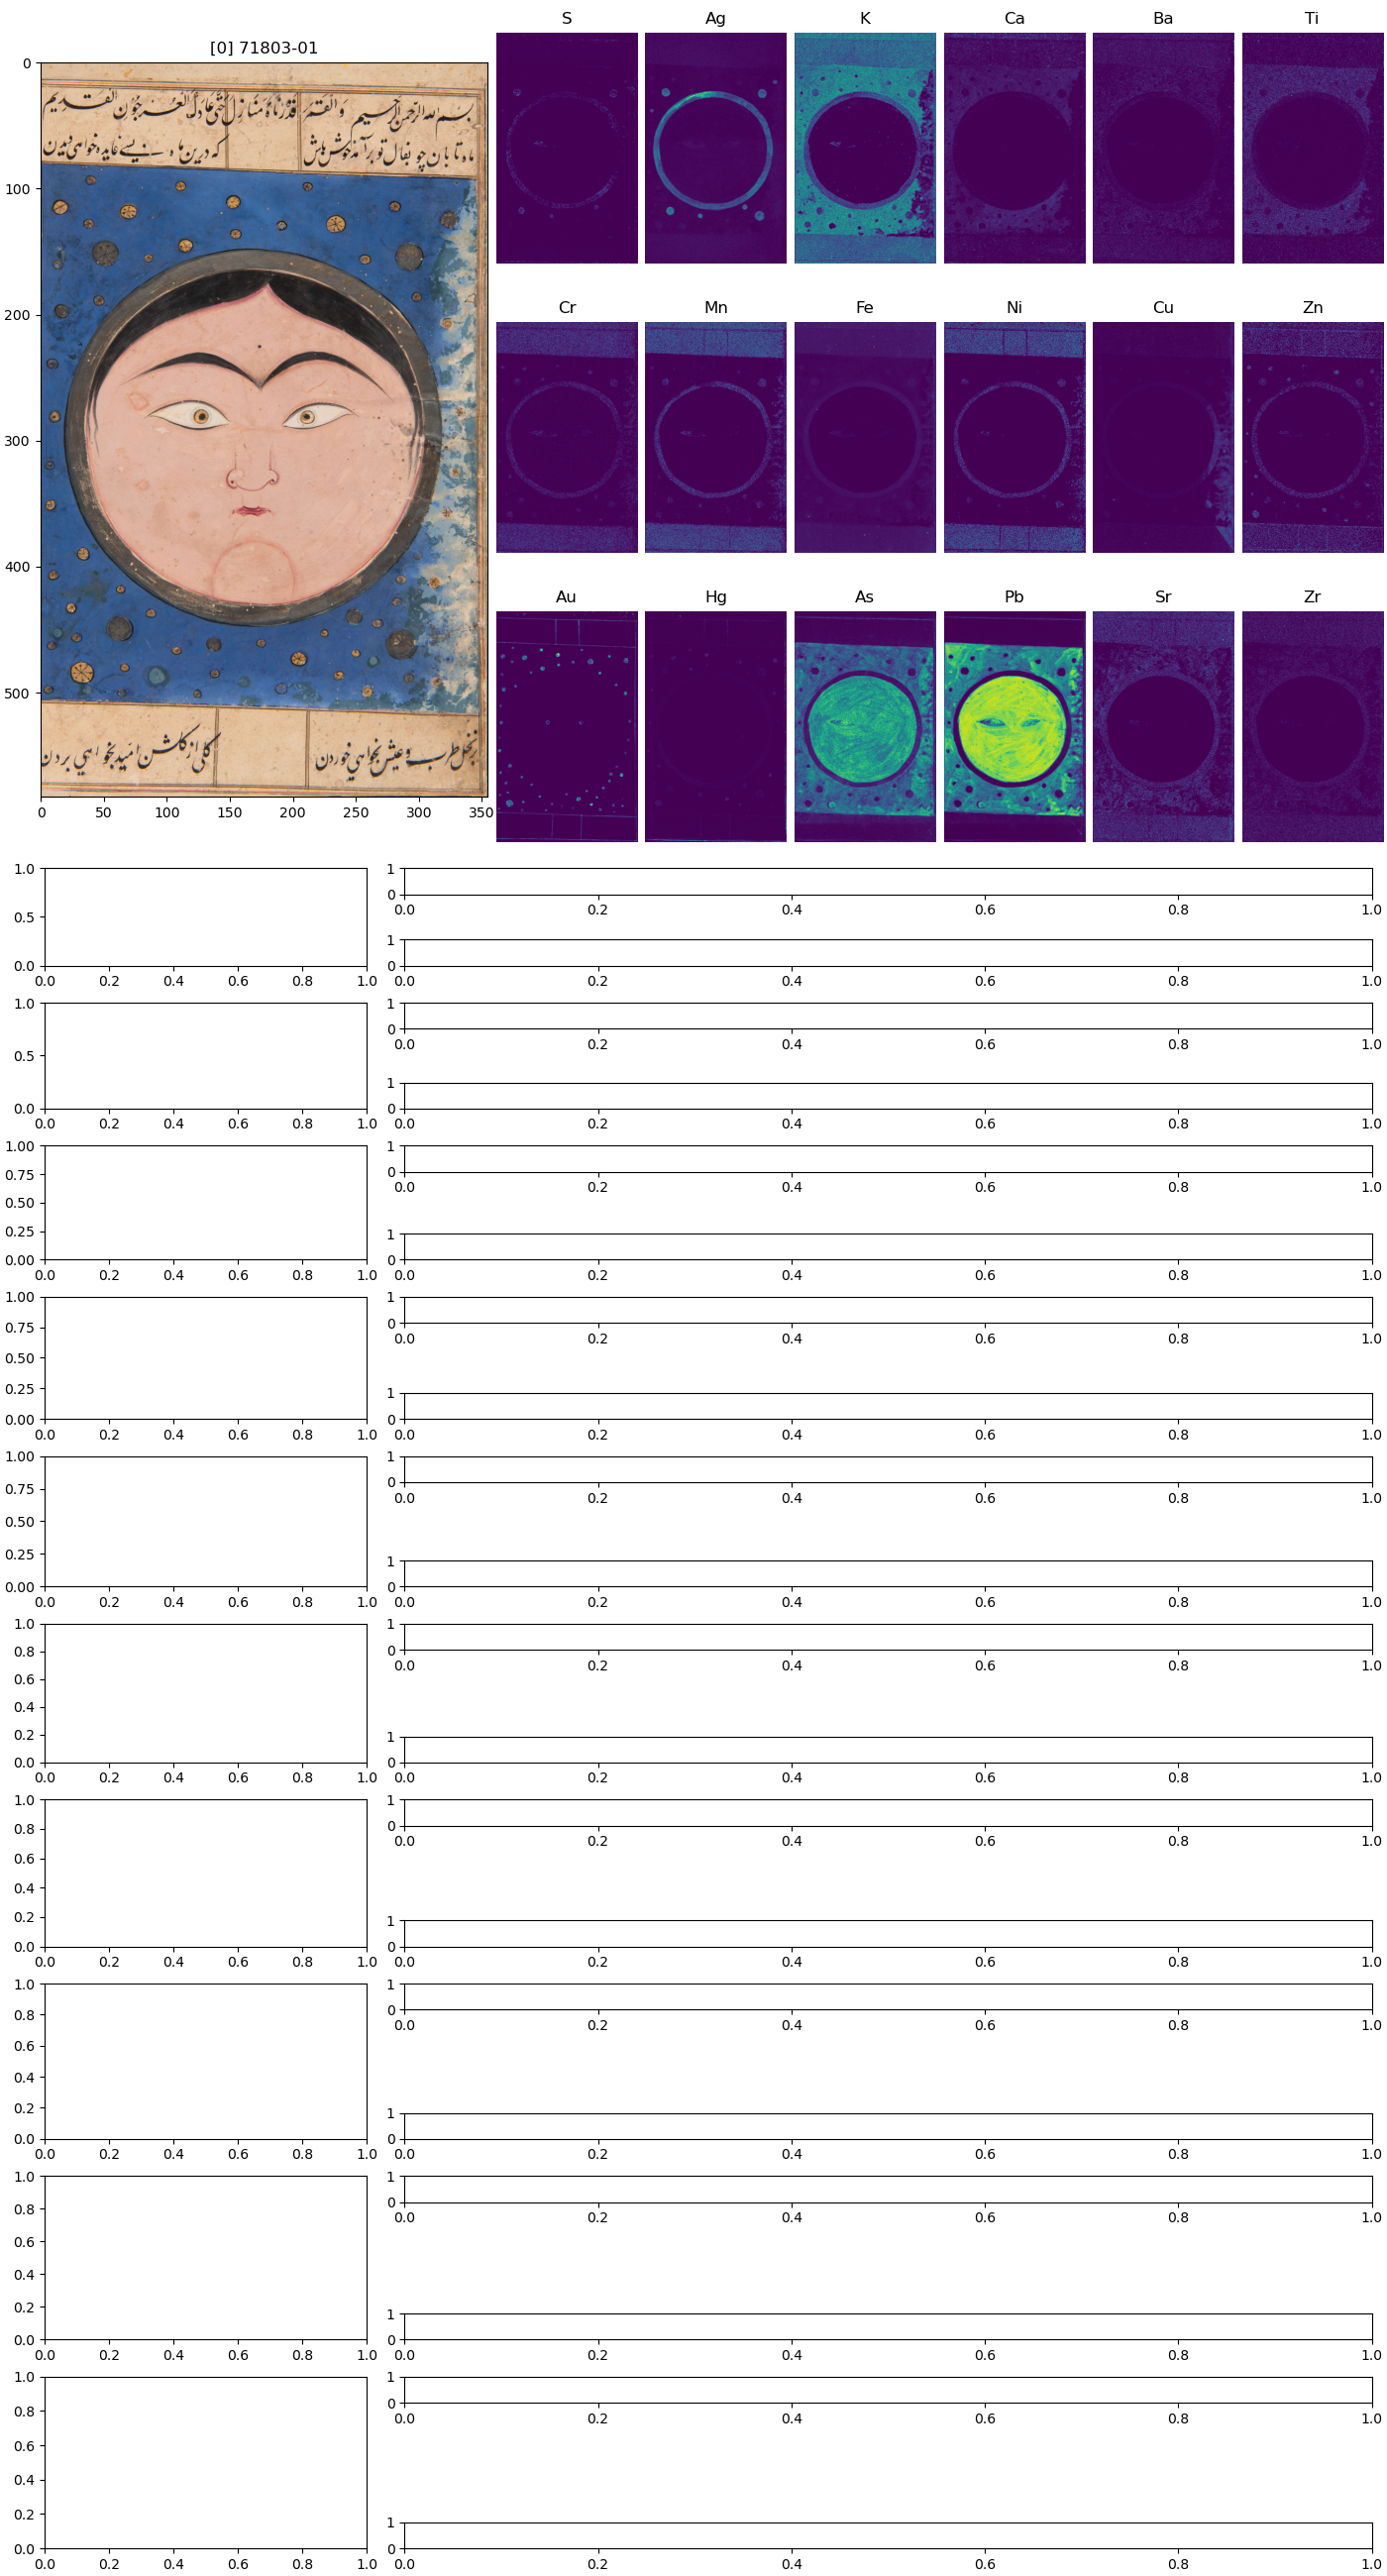

In [5]:
file = [datastack_file, datastack_file2]
dash = Dashboard(file)

In [6]:
dash.add_roi(1, (90, 150), (265, 295))

In [8]:
dash.add_roi(0, *dash.get_selection_coords())

In [9]:
dash.add_mos_element(0, 'Pb')

/home/koen-van-tilburg/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/moseley/mplot.py:304: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [10]:
dash.add_mos_element(0, 'Hg')

In [117]:
dash.add_mos_element(2, 'Au')

In [118]:
dash.remove_mos_element(1, 'Pb')

In [ ]:
dash.swap_image(1)

In [120]:
dash.get_data()

[{'object_name': '71803-01',
  'rois': [None,
   ((90, 150), (265, 295)),
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None],
  'mos_elements': [None,
   ['K'],
   ['Au'],
   None,
   None,
   None,
   None,
   None,
   None,
   None]},
 {'object_name': '71803-10',
  'rois': [None, None, None, None, None, None, None, None, None, None],
  'mos_elements': [None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None,
   None]}]